# Leveraging Business and Engineering Metrics with Ml-Powered Scorecards

Before diving into the intricacies of the Mahcine Learning Algorithms and Product Health Scoerecards, let's start with generating some data for our hypothetical business, *RandomCats, Inc.,* which is in business of generating images of random cats. They sell an API, have a website, mobile apps on both Android and iOS. 

## Part I: RandomCats Data generation

First, let's import all the needed packages.

In [192]:
import pandas as pd
import numpy as np
import random
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import requests


Now let's generate some dates!

In [193]:
days = 180

products = ['API']#, 'Web', 'Android', 'iOS']

start_date = datetime(2023, 1, 1)  
end_date = start_date + timedelta(days=days)

dates = pd.date_range(start=start_date, end=end_date, freq='D')

print("Number of dates:", len(dates))

Number of dates: 181


### Reliability Data Generation

In [194]:
def generate_reliability():
    return round(random.uniform(95.0, 100.0), 2)


In [195]:
reliability_data = []
for date in dates:
    for product in products:
        record = {
            'Date': date,
            'Product': product,
            'Reliability (%)': generate_reliability(),
        }
        reliability_data.append(record)
        
rdf = pd.DataFrame(reliability_data)
rdf['Date'] = pd.to_datetime(rdf['Date'])
display(rdf)

,Date,Product,Reliability (%)
0,2023-01-01,API,95.31
1,2023-01-02,API,96.15
2,2023-01-03,API,98.46
3,2023-01-04,API,99.56
4,2023-01-05,API,99.29
...,...,...,...
176,2023-06-26,API,97.24
177,2023-06-27,API,98.30
178,2023-06-28,API,95.77
179,2023-06-29,API,95.70


### Performance Data Generation

In [196]:
def generate_performance():
    return round(random.uniform(100, 500), 2)

In [197]:
perf_data = []
for date in dates:
    for product in products:
        record = {
            'Date': date,
            'Product': product,
            'Performance (ms)': generate_performance(),
        }
        perf_data.append(record)
        
pdf = pd.DataFrame(perf_data)
pdf['Date'] = pd.to_datetime(pdf['Date'])
display(pdf)

,Date,Product,Performance (ms)
0,2023-01-01,API,131.54
1,2023-01-02,API,176.93
2,2023-01-03,API,196.05
3,2023-01-04,API,232.66
4,2023-01-05,API,291.19
...,...,...,...
176,2023-06-26,API,473.58
177,2023-06-27,API,424.42
178,2023-06-28,API,213.40
179,2023-06-29,API,457.76


### Let's graph them!

In [198]:
def plot(df, label, date_label = 'Date'):
    sns.set_theme()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=date_label, y=label, hue='Product')
    plt.title(f'Product {label} Over Time', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Product', loc='lower right')
    plt.tight_layout()
    plt.show()

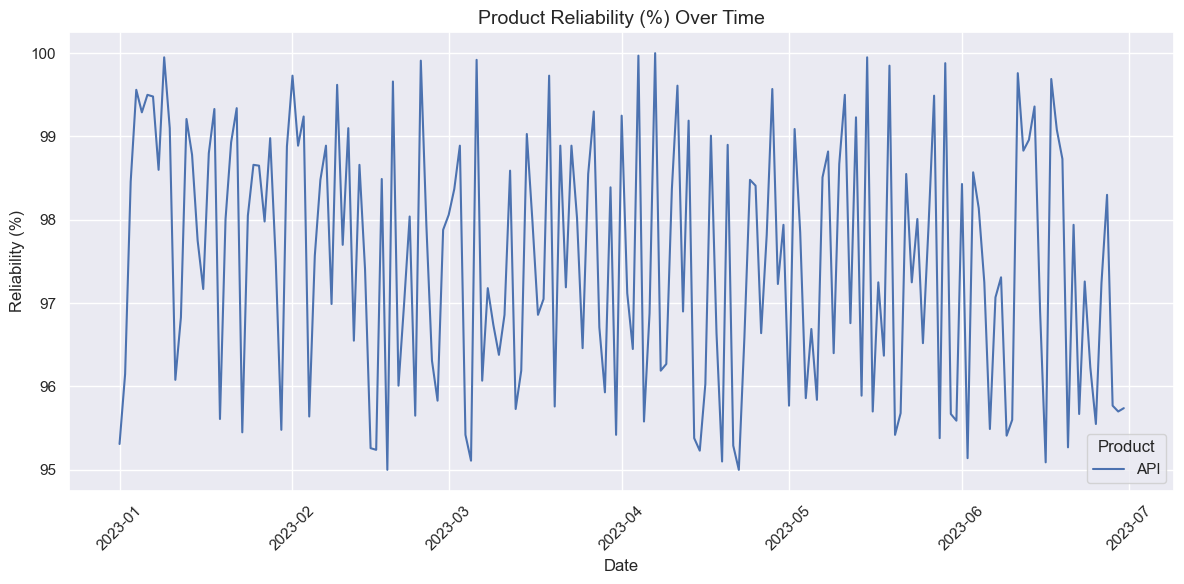

In [199]:
plot(rdf, 'Reliability (%)')

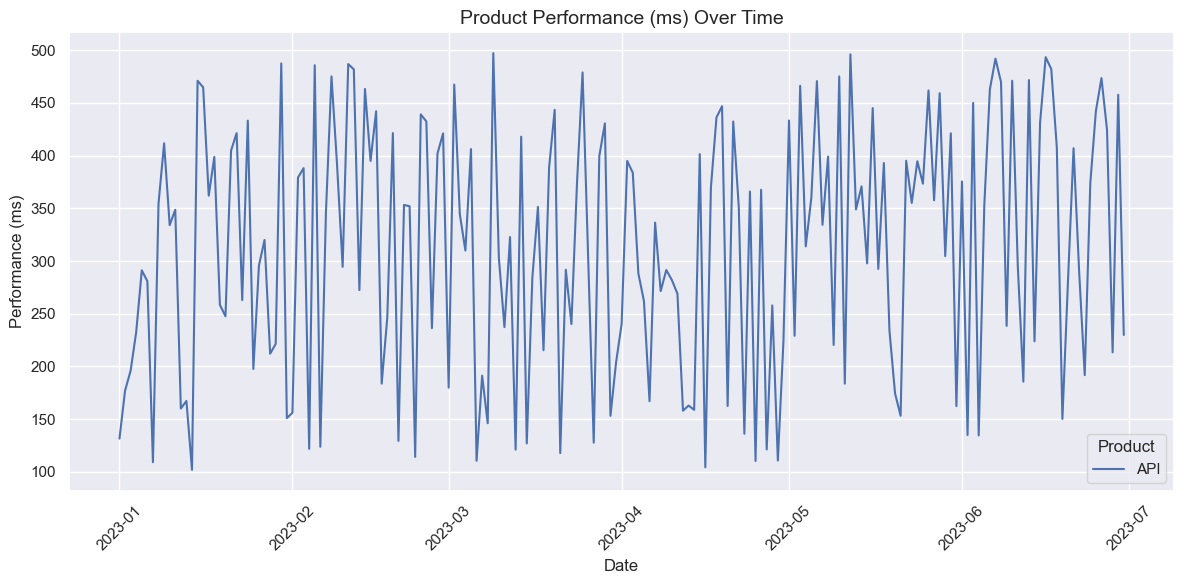

In [200]:
plot(pdf, 'Performance (ms)')

### Business Metrics Data Generation: WAU and Churn
Both of the metrics are generated taking reliability and performance into consideration

In [201]:
def calculate_wau(reliability, performance, base_wau=10000):
    wau_modifier = 1 + (reliability - 90) / 100 - (performance - 250) / 500
    # Modify WAU based on reliability and performance
    wau = base_wau * wau_modifier  
    return max(0, int(wau)) 

def calculate_churn(reliability, performance):
    # Higher reliability -> Lower churn, worse performance -> higher churn
    churn_probability = (100 - reliability) / 100 + (performance - 250) / 500
    churn_probability = np.clip(churn_probability, 0, 1)
    churn = np.random.binomial(1, churn_probability)  
    return churn

In [202]:
weeks = pd.date_range(start=start_date, end=end_date, freq='W')

data = []

for week in weeks:
    for product in products:
        reliability = generate_reliability()
        performance = generate_performance()
        wau = calculate_wau(reliability, performance)
        churn = calculate_churn(reliability, performance)
        
        record = {
            'Week': week,
            'Product': product,
            'Reliability (%)': reliability,
            'Performance (ms)': performance,
            'WAU': wau,
            'Churn': churn
        }
        data.append(record)

# Create a DataFrame
df = pd.DataFrame(data)

df['Week'] = pd.to_datetime(df['Week'])
# Display the first few rows of the dataset
print(df.head())

        Week Product  Reliability (%)  Performance (ms)    WAU  Churn
0 2023-01-01     API            99.60            403.02   7899      0
1 2023-01-08     API            97.43            392.57   7891      0
2 2023-01-15     API            97.09            115.13  13406      0
3 2023-01-22     API            98.23            150.16  12819      0
4 2023-01-29     API            99.42            477.02   6401      0


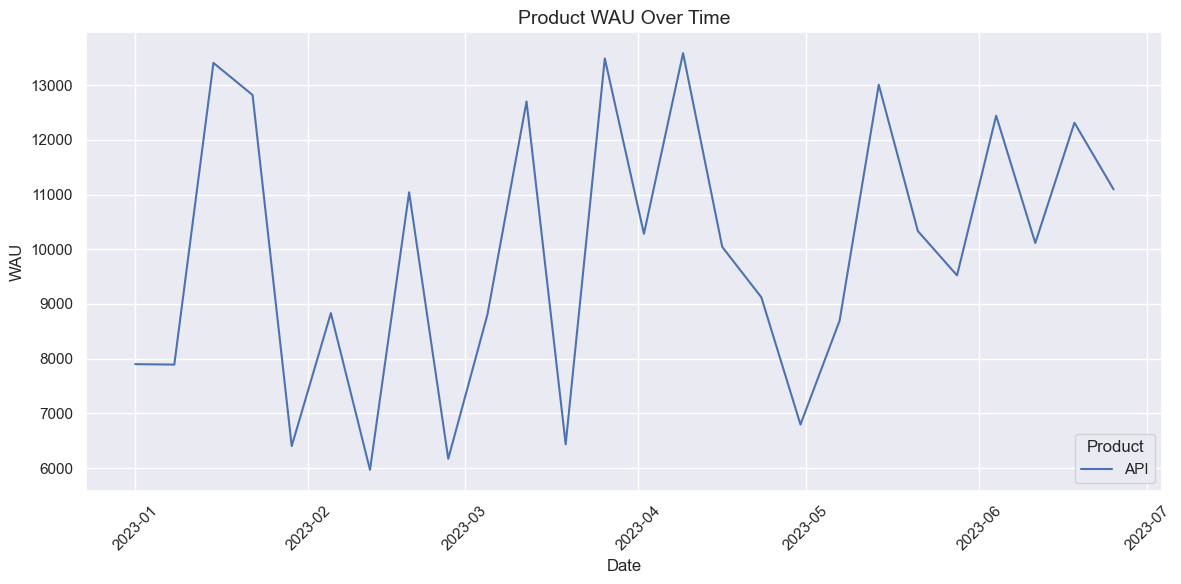

In [203]:
plot(df, 'WAU', date_label='Week')

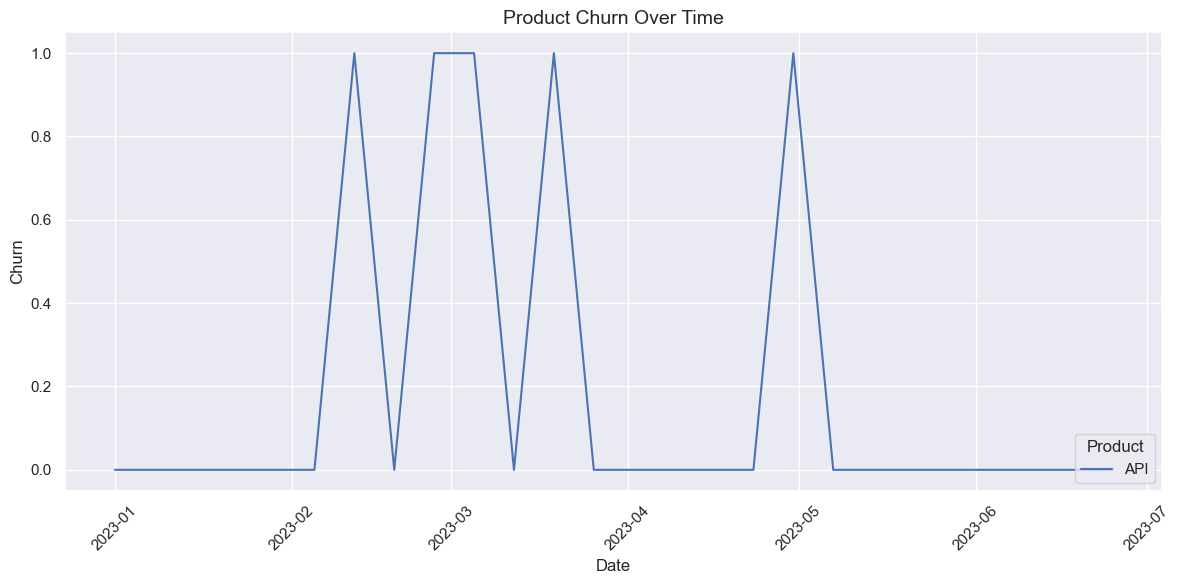

In [204]:
plot(df, 'Churn', date_label='Week')

# Part II: Prediction of Churn 

## Testing for Correlation with Pearson Correlation Method

The Pearson correlation coefficient $ r $ between two variables $ X $ and $ Y $ is given by the formula:

$$
r = \frac{ \sum{(X_i - \overline{X})(Y_i - \overline{Y})} }{ \sqrt{ \sum{(X_i - \overline{X})^2} } \sqrt{ \sum{(Y_i - \overline{Y})^2} } }
$$

Where:

- $ X_i $ and $ Y_i $ are the individual data points of variables $ X $ and $ Y $.
- $ \overline{X} $ and $ \overline{Y} $ are the means of $ X $ and $ Y $, respectively.
- $ r $ ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation.

The $ p $-value tells us the significance of the correlation (typically, a $ p $-value less than 0.05 is considered statistically significant).


In [205]:
correlation, p_value = pearsonr(df['Performance (ms)'], df['Churn'])

print(f"Pearson correlation between Performance and Churn: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Pearson correlation between Performance and Churn: 0.6209
P-value: 0.0007


In [206]:
correlation, p_value = pearsonr(df['Reliability (%)'], df['Churn'])

print(f"Pearson correlation between Reliability and Churn: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Pearson correlation between Reliability and Churn: 0.0656
P-value: 0.7500


## Build a logistic regression model
Let's start by splitting the dataset into training and test subsets. The suggested breakdown in the industry is 80/20, so this is what we do:

In [207]:
X = df[['Reliability (%)', 'Performance (ms)']] 
y = df['Churn'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

With the model trained, we can test it using our test data set and check for its accuracy.

It also shows the confusion matrix, and classification report showing how good the model is, including precision, recall and f-score 

In [210]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}\n")

print("Classification Report:\n", classification_report(y_test, y_pred))

print(f"Model Coefficients: {model.coef_}")

Accuracy: 0.6666666666666666
Confusion Matrix:
[[3 0]
 [2 1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6

Model Coefficients: [[-0.78261849  0.04443314]]


In [218]:
y_total = model.predict(X)
y_total_series = pd.Series(y_total, name='Predicted Churn')

df_with_predictions = df.copy()
df_with_predictions['Predicted Churn'] = y_total_series.values

df_with_predictions.to_csv('product_reliability_performance.csv', index=False)

# Part III: Send your data to a product health scorecard

What you use for scorecarding does not matter, as long as it is consistently evaluated by engineering and product.

You can build it in a Google sheet like this: https://shorturl.at/p1Vuy.

Or use something more sophisticated like a scorecard inside a developer portal. The one I use here is called [Port](https://www.getport.io/). 

_Note: I am not affiliated with Port and they are not paying me to do recommend. I happen to just like their product._

In [234]:
CLIENT_ID = ''
CLIENT_SECRET = ''

API_URL = 'https://api.getport.io/v1'

credentials = {'clientId': CLIENT_ID, 'clientSecret': CLIENT_SECRET}

token_response = requests.post(f'{API_URL}/auth/access_token', json=credentials)

access_token = token_response.json()['accessToken']

headers = {
	'Authorization': f'Bearer {access_token}'
}

blueprint_id = 'random_cats_product'
for index, row in df_with_predictions.iterrows():
    entity = {
      "identifier": str(hash(row['Week']) % 10000),
      "title": row['Week'].strftime("%Y-%m-%d"),
      "properties": {
        "platform": "API",
        "performance": row['Performance (ms)'],
        "reliability": row['Reliability (%)'],
        "wau": row['WAU'],
        "churn": row['Churn'],
        "predicted_churn": row['Predicted Churn'],
      },
      "relations": {}
    }
    print(entity)
    #print(requests.post(f'{API_URL}/blueprints/{blueprint_id}/entities?upsert=true', json=entity, headers=headers).json())


{'ok': True, 'entity': {'identifier': '3677', 'title': '2023-01-01', 'blueprint': 'random_cats_product', 'team': [], 'properties': {'platform': 'API', 'performance': 403.02, 'reliability': 99.6, 'wau': 7899, 'churn': False, 'predicted_churn': False}, 'relations': {}, 'createdAt': '2024-10-20T15:27:46.882Z', 'createdBy': 'fVfUQWJrephvO3j5PBhUxicGP3gz5Rff', 'updatedAt': '2024-10-20T15:27:46.882Z', 'updatedBy': 'fVfUQWJrephvO3j5PBhUxicGP3gz5Rff'}}
{'ok': True, 'entity': {'identifier': '7383', 'title': '2023-01-08', 'blueprint': 'random_cats_product', 'team': [], 'properties': {'platform': 'API', 'performance': 392.57, 'reliability': 97.43, 'wau': 7891, 'churn': False, 'predicted_churn': False}, 'relations': {}, 'createdAt': '2024-10-20T15:27:48.250Z', 'createdBy': 'fVfUQWJrephvO3j5PBhUxicGP3gz5Rff', 'updatedAt': '2024-10-20T15:27:48.250Z', 'updatedBy': 'fVfUQWJrephvO3j5PBhUxicGP3gz5Rff'}}
{'ok': True, 'entity': {'identifier': '5181', 'title': '2023-01-15', 'blueprint': 'random_cats_produc